<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

## Import libraries and dependencies

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, IterableDataset
from PIL import Image
import torchvision.transforms as transforms
import os
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from transformers import OPTForCausalLM, GPT2Tokenizer
from transformers import CLIPVisionModel, CLIPVisionConfig
from typing import Optional , List
from transformers import AutoTokenizer , AutoModel
import random
from transformers import CLIPTextModel, CLIPTokenizer

/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def contrastive_loss(logits):
  return torch.nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))

## UniMUR training

In [3]:


class FrozenArgs:
  freeze_lm: bool = False
  freeze_vm: bool = True
  opt_version: str = 'facebook/opt-125m'
  visual_encoder: str = 'openai/clip-vit-large-patch14'
  n_visual_tokens: int = 1
  task: str = 'captioning'
  shared_emb_dim: Optional[int] = 768
  text_emb_layers: List[int] = [-1]
  retrieval_token_idx: int = 50265


class uniMURModel(nn.Module):
  def __init__(self, tokenizer, args: FrozenArgs = FrozenArgs()):
    super().__init__()
    self.tokenizer = tokenizer
    self.args = args

    opt_version = args.opt_version
    visual_encoder = args.visual_encoder
    n_visual_tokens = args.n_visual_tokens

    self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    # nn.Parameter inherently sets requires_grad=True
    # it is trainable

    if 'facebook/opt' in opt_version:
      self.lm = OPTForCausalLM.from_pretrained(opt_version)
    else:
      raise NotImplementedError

    self.opt_version = opt_version

    if self.args.freeze_lm:
      self.lm.eval()
      print("Freezing the LM.")
      for param in self.lm.parameters():
        param.requires_grad = False
    else:
      self.lm.train()

    # NOTE: Resizing sets all token embeddings and all lm_head weights (since they are tied in OPT)
    # to be trainable (param.requires_grad = True).
    self.retrieval_token_idx = args.retrieval_token_idx
    self.lm.resize_token_embeddings(len(tokenizer))
    self.input_embeddings = self.lm.get_input_embeddings() #model.model.input_embeddings() ke parameters 

    self.visual_model = CLIPVisionModel.from_pretrained(visual_encoder)

    hidden_size = self.visual_model.config.hidden_size
  
    self.visual_model.eval()
    for param in self.visual_model.parameters():
      param.requires_grad = False

    self.visual_model_name = visual_encoder
    embedding_dim = self.input_embeddings.embedding_dim * self.args.n_visual_tokens
    self.text_hidden_fcs = nn.ModuleList([])
    out_dim = self.args.shared_emb_dim
    in_dim = self.lm.config.word_embed_proj_dim
    text_fc = [nn.Linear(in_dim, out_dim)]
    self.text_hidden_fcs.append(nn.Sequential(*text_fc))
    self.visual_embeddings = nn.Linear(hidden_size, embedding_dim)

  def get_visual_embs(self, pixel_values: torch.FloatTensor, mode: str = 'captioning'):
    if mode not in ['captioning', 'retrieval']:
      raise ValueError(f'mode should be one of ["caption", "retrieval"], got {mode} instead.')

    # Extract visual embeddings from the vision encoder.
    if 'clip' in self.visual_model_name:
      outputs = self.visual_model(pixel_values)
      encoder_outputs = outputs.pooler_output
    else:
      raise NotImplementedError

    #language like tokens
    # Use the correct fc based on function argument.
    visual_embs = self.visual_embeddings(encoder_outputs)  # (2, D * n_visual_tokens)
    visual_embs = torch.reshape(visual_embs, (visual_embs.shape[0], self.args.n_visual_tokens, -1))
    return visual_embs


  def train(self, mode=True):
    super(uniMURModel, self).train(mode=mode)
    # Overwrite train() to ensure Frozen models remain frozen.
    if self.args.freeze_lm:
      self.lm.eval()
    if self.args.freeze_vm:
      self.visual_model.eval()


  def forward(
    self,
    pixel_values: torch.FloatTensor,
    labels: torch.LongTensor,
    caption_len: torch.LongTensor,
    mode: str = 'captioning',
    concat_captions: bool = False
  ):
    visual_embs = self.get_visual_embs(pixel_values, mode)

    batch_size, vis_seq_len, _ = visual_embs.shape  # vis_seq_len = n_visual_tokens
    if labels is not None:
      assert labels.shape[0] == batch_size, (visual_embs.shape, labels.shape)

    input_embs = self.input_embeddings(labels)  # (N, T, D)

    
    if mode == 'captioning':
      # Concat to text embeddings.
      # Just add visual embeddings.
      input_embs = torch.cat([visual_embs, input_embs], axis=1)
      full_labels = torch.zeros(visual_embs.shape[:2], dtype=torch.int64).to(visual_embs.device) - 100
      # -100 at the places where where no need to predict == # Mask out embedding tokens in the labels.
      
      full_labels = torch.cat([full_labels, labels], axis=1)
      pad_idx = []
      for label in full_labels:
        for k, token in enumerate(label):
          # Mask out retrieval token if it exists.
          if token in [self.tokenizer.pad_token_id]:
            label[k:] = -100
            pad_idx.append(k)
            break
          if k == len(label) - 1:  # No padding found.
            pad_idx.append(k + 1)

      if concat_captions:
        assert batch_size % 2 == 0 #alert if not even
        all_concat_input_embs = []
        all_concat_labels = []

        # Rearrange embeddings and labels (and their padding) to concatenate captions.
        # 1,2 ... 3,4 ... 5,6
        for i in range(batch_size // 2):
          first_idx = i * 2
          second_idx = first_idx + 1
          first_emb = input_embs[first_idx, :pad_idx[first_idx], :]
          first_labels = full_labels[first_idx, :pad_idx[first_idx]]
          first_padding = input_embs[first_idx, pad_idx[first_idx]:, :]
          first_labels_padding = full_labels[first_idx, pad_idx[first_idx]:]

          second_emb = input_embs[second_idx, :pad_idx[second_idx], :]
          second_labels = full_labels[second_idx, :pad_idx[second_idx]]
          second_padding = input_embs[second_idx, pad_idx[second_idx]:, :]
          second_labels_padding = full_labels[second_idx, pad_idx[second_idx]:]

          concat_input_embs = torch.cat([first_emb, second_emb, first_padding, second_padding], axis=0)   # (T*2, 768)
          concat_labels = torch.cat([first_labels, second_labels, first_labels_padding, second_labels_padding], axis=0)   # (T*2, 768)
          all_concat_input_embs.append(concat_input_embs)
          all_concat_labels.append(concat_labels)

        # Pad to max length.
        input_embs = torch.stack(all_concat_input_embs, axis=0)  # (N/2, T*2, 768)
        full_labels = torch.stack(all_concat_labels, axis=0)  # (N/2, T*2, 768)

      output = self.lm(inputs_embeds=input_embs,
                       labels=full_labels,
                       output_hidden_states=True)
    elif mode == 'retrieval':
      full_labels = torch.clone(labels)
      pad_idx = []
      last_embedding_idx=[]
      for label in full_labels:
        for k, token in enumerate(label):
          if token == self.tokenizer.pad_token_id:
            label[k:] = -100
            pad_idx.append(k)
            last_embedding_idx.append(k-2)
            break
          if k == len(label) - 1:  # No padding found.
            pad_idx.append(k + 1)
            last_embedding_idx.append(k+1-2)

      output = self.lm(inputs_embeds=input_embs,
                       labels=full_labels,
                       output_hidden_states=True)
    else:
      raise NotImplementedError

    last_embedding = None
    hidden_states = []


    if mode == 'retrieval':
      for idx, fc_layer in zip(self.args.text_emb_layers, self.text_hidden_fcs):
          hidden_states.append(fc_layer(output.hidden_states[idx]))  # (N, seq_len, 768)
          # output.hidden_states[-1] are the outputs of the last layer
          # print(full_labels.size())
          # print(hidden_states[-1].size()) are equal in dims except the third dim

      last_hidden_state =hidden_states[-1]

      if not concat_captions:
        last_embedding = torch.stack([last_hidden_state[i, last_embedding_idx[i], :] for i in range(batch_size)], axis=0)  # (N, D)
      else:
        raise NotImplementedError

      # Compute retrieval loss.
      visual_embs = visual_embs[:, 0, :]
      visual_embs = visual_embs / visual_embs.norm(dim=1, keepdim=True)
      last_embedding = last_embedding / last_embedding.norm(dim=1, keepdim=True)

      logit_scale = self.logit_scale.exp()
      visual_embs = logit_scale * visual_embs
    elif mode == 'captioning':
      pass
    else:
      raise NotImplementedError

    return output, full_labels, last_embedding, visual_embs

  

class uniMUR(nn.Module):
  def __init__(self, tokenizer, model_args: Optional[FrozenArgs] = None):
    super().__init__()
    self.model = uniMURModel(tokenizer, model_args)

  def __call__(self, images: Tensor, tgt_tokens: Optional[Tensor] = None, caption_len: Optional[Tensor] = None,
               mode: str = 'captioning', concat_captions: bool = False) -> Tensor:
    output = self.model(
        pixel_values = images,
        labels = tgt_tokens,
        caption_len = caption_len,
        mode = mode,
        concat_captions = concat_captions)
    return output


In [4]:
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m', use_fast=False)

model_args = FrozenArgs()
model_args.opt_version = 'facebook/opt-125m'
model_args.freeze_lm = False
model_args.visual_encoder = "openai/clip-vit-large-patch14"
model_args.freeze_vm = True
model_args.n_visual_tokens = 1
model_args.shared_emb_dim = 768
model_args.text_emb_layers = [-1]
model_args.retrieval_token_idx = 50265



print('Adding [RET] token to vocabulary.')
print('Before adding new token, tokenizer("[RET]") =', tokenizer('[RET]', add_special_tokens=False))
num_added_tokens = tokenizer.add_tokens('[RET]')
print(f'After adding {num_added_tokens} new tokens, tokenizer("[RET]") =', tokenizer('[RET]', add_special_tokens=False))
ret_token_idx = tokenizer('[RET]', add_special_tokens=False).input_ids
assert len(ret_token_idx) == 1, ret_token_idx
model_args.retrieval_token_idx = ret_token_idx[0]

model = uniMUR(tokenizer, model_args)

# for param in model.model.input_embeddings.parameters():
#     print(param.grad)

Adding [RET] token to vocabulary.
Before adding new token, tokenizer("[RET]") = {'input_ids': [10975, 36995, 742], 'attention_mask': [1, 1, 1]}
After adding 1 new tokens, tokenizer("[RET]") = {'input_ids': [50265], 'attention_mask': [1]}


In [5]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer_cls = torch.optim.AdamW

optimizer = optimizer_cls(
    model.parameters(), 
    0.0002, 
    betas=(0.85, 0.999),  # 
    weight_decay=  0.01, # if not generalises well Weight Decay (0.01) Weight decay (L2 regularization) helps prevent overfitting by penalizing large weights.
    eps=1e-8
)



In [6]:

#slicing 
no_of_datapoints= 20000 #failry large
dataset = load_dataset("liuhaotian/LLaVA-CC3M-Pretrain-595K", streaming=True, split='train').take(no_of_datapoints)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# transform = transforms.ToTensor() -- modification , (224, 224) wrt patch -14 - small no of patches
data_list = []
for example in dataset:
    image = Image.open(f'images/{example["image"]}')
    image = transform(image)
    caption = example["conversations"][1]['value']
    data_list.append((image, caption))
print(f"Collected {no_of_datapoints} samples.")

Collected 20000 samples.


In [7]:
random.shuffle(data_list)
train_data= data_list[:int(0.85*no_of_datapoints)]
test_data= data_list[int(0.85*no_of_datapoints) : ]

max_length = 64
token_len = max_length

class ImageCaptionDataset():
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
text_model_name = model_args.visual_encoder
text_model = CLIPTextModel.from_pretrained(text_model_name)
text_tokenizer = CLIPTokenizer.from_pretrained(text_model_name) # no tokenizer for vision
text_model.cuda()

def verify_tokenizer_by_decoding(input_ids, tokenizer, max_length = 64, padding=True, truncation=True):
    for i, token_ids in enumerate(input_ids):
        decoded_text = tokenizer.decode(token_ids, skip_special_tokens=False)
        print(f"  Decoded : {decoded_text}")


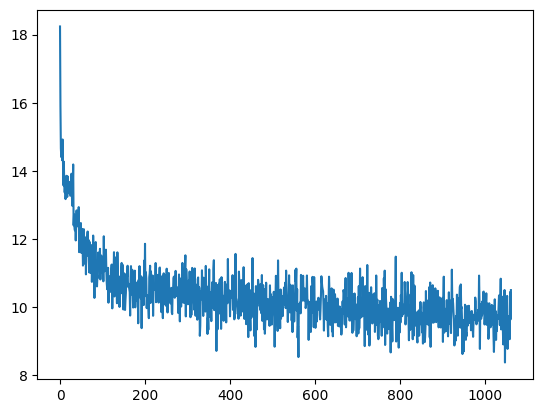

In [9]:
model.cuda()
model.train()
no_of_epochs , sample = 1 , 0
loss_values = []
ret_loss_scale = 1
grad_clip = 1


# why to explicit make them True , they should trainable
# for param in model.model.input_embeddings.parameters():
#     param.requires_grad = True

for no in range(0,no_of_epochs):
    batch_size = 16
    train_loader = DataLoader(ImageCaptionDataset(train_data), batch_size=batch_size, shuffle=True, drop_last=True)
    for images, captions in train_loader:
        images= images.cuda()
        model_modes = ['captioning', 'retrieval']
        loss = 0

        text_tokens = text_tokenizer(captions ,  return_tensors="pt", padding=True, truncation=True , max_length = max_length,add_special_tokens=False).input_ids.cuda()
        
        text_outputs = text_model(input_ids=text_tokens)
        cls_token_embs = text_outputs.last_hidden_state[:, 0, :]

        captions = tuple(f"a photo of {caption}[RET]</s>" for caption in captions)
        labels = tokenizer(captions, return_tensors="pt", padding=True, truncation = True , max_length = max_length, add_special_tokens=False).input_ids.cuda()
        tgt_tokens = labels

        model_modes = ['captioning', 'retrieval']
        loss = 0
        for mode in model_modes:
            if mode == 'captioning':
                concat_captions = True
            else :
                concat_captions = False
            (model_output, full_labels, last_embedding, visual_embs) = model(images, tgt_tokens, token_len, mode=mode , concat_captions=concat_captions)
            

            loss = loss +  model_output.loss
            if mode == 'retrieval':
                logits_per_image = visual_embs @ last_embedding.t()
                logits_per_text = logits_per_image.t()
                caption_loss = contrastive_loss(logits_per_text)
                image_loss = contrastive_loss(logits_per_image)
                loss += ret_loss_scale * (caption_loss + image_loss) / 2.0
                loss += ret_loss_scale*F.mse_loss(last_embedding , cls_token_embs)

        optimizer.zero_grad()
        loss.backward()


        # each param has matrix of grad for each embedding of the model
        for param in model.model.input_embeddings.parameters():
            assert param.grad.shape[0] == len(tokenizer)
            # Keep other embeddings frozen.
            mask = torch.arange(param.grad.shape[0]) != model_args.retrieval_token_idx
            param.grad[mask, :] = 0
        
        
        if grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        with torch.no_grad():
            # Normalize trainable embeddings.
            frozen_norm = torch.norm(model.model.input_embeddings.weight[:-1, :], dim=1).mean(0)
            trainable_weight = model.model.input_embeddings.weight[-1, :]
            model.model.input_embeddings.weight[-1, :].div_(torch.norm(trainable_weight) / frozen_norm)
            # brings training stability , maintaining scability
        loss_values.append(loss)

loss_values_floats = [loss.item() for loss in loss_values]
plt.plot(loss_values_floats)

#  Caption generation

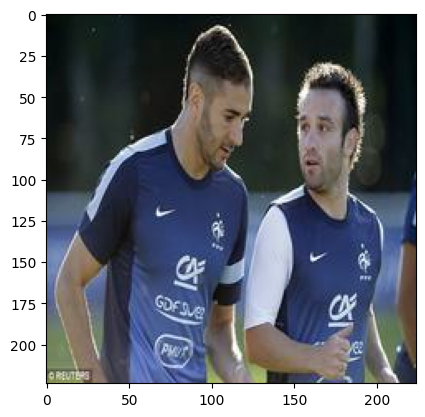

['football player has not featured for the team since the scandal broke']
['a photo of person , who was named in the match , was given out after he was given out by footballer , who was given out by footballer [RET] </s>']





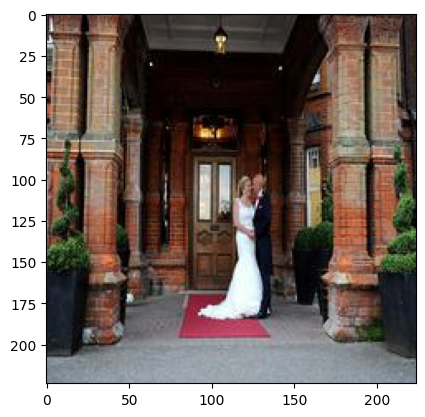

['happy newlyweds striking a romantic pose out on the red carpet at the entrance']
['a photo of a wedding dress is a wedding cake for a bride and groom [RET] </s>']





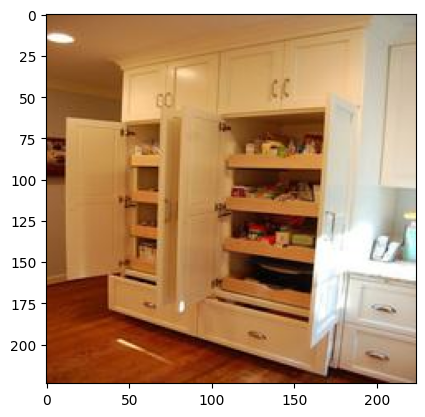

['pull out shelves in kitchen cabinets ... this would be great in a craft room !']
['a photo of the kitchen countertops are set up for a large island . [RET] </s>']





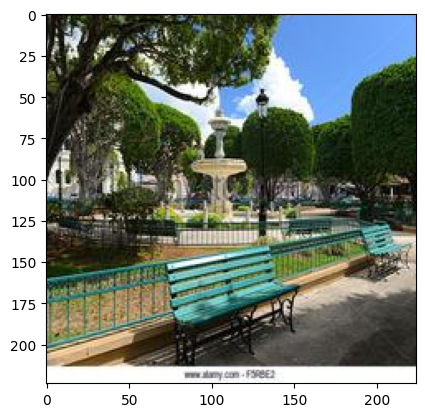

['water fountain at the town .']
['a photo of a street corner in the area [RET] </s>']





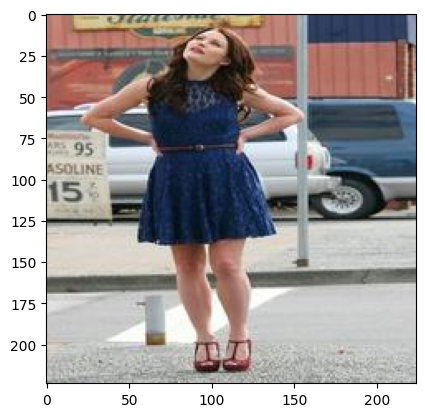

['still of actor in adventure tv program .']
['a photo of a model walks the runway at the show during the fall season . [RET] </s>']





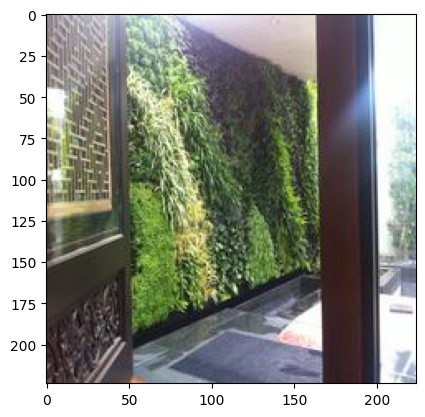

['entry way of a home .']
['a photo of the garden in the garden [RET] </s>']





In [10]:
image_cnt = 0
references, predictions = {}, {}
model.cuda()
model.eval()

for test_image, ground_truth in test_data:
    image_cnt += 1
    img = test_image
    test_image = test_image.cuda()
    test_image  = test_image.unsqueeze(0) #for batch
    visual_embeds = model.model.get_visual_embs(test_image , mode  = 'captioning')
    #language like token

    embeddings = visual_embeds
    out = None
    past_key_values = None
    generated_tokens = []

    with torch.no_grad():  # Disable gradient tracking
        for i in range(max_length):
            # First step uses embeddings, subsequent steps use `out`
            if i == 0:
                output = model.model.lm(
                    inputs_embeds=embeddings,
                    use_cache=True,
                    past_key_values=None,
                    output_hidden_states=False
                )
            else:
                output = model.model.lm(
                    input_ids=out[:, -1:],  # Last generated token
                    use_cache=True,
                    past_key_values=past_key_values,
                    output_hidden_states=False
                )

            logits = output.logits[:, -1, :]  # raw stuff before applying any softmax ,sigmoid etc
            past_key_values = output.past_key_values
            
            # Greedy decoding (replace with sampling if needed)
            next_token = torch.argmax(logits, dim=-1, keepdim=True) 
            generated_tokens.append(next_token.item())

            # Update `out` with the new token
            if out is None:
                out = next_token
            else:
                out = torch.cat([out, next_token], dim=-1)

            # Break on special tokens (e.g., [EOS])
            if next_token.item() == tokenizer.eos_token_id:
                break

    generated_with_special = tokenizer.decode(generated_tokens, skip_special_tokens=False)
    references[image_cnt] = [ground_truth]
    predictions[image_cnt] = [generated_with_special]

    if image_cnt>=0 and image_cnt<=6:
        plt.imshow(img.permute(1,2,0))
        plt.show()
        print(references[image_cnt])
        print(predictions[image_cnt])
        print("\n\n")
    references[image_cnt] = [f"a photo of {ground_truth}[RET]</s>"]


In [11]:
from pycocoevalcap.cider.cider import Cider

# Compute CIDEr score
scorer = Cider()
score, _ = scorer.compute_score(references, predictions)

# Output the results
print(f"CIDEr Score: {score/10}")

CIDEr Score: 0.012602474466923832


# Recall

Precompute for the test set

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
precompute_img_features = []
precompute_tex_features= []
model.cuda()
model.eval()


for test_image , caption in test_data:
    test_image = test_image.unsqueeze(0)
    test_image =test_image.cuda()
    visual_embeds = model.model.get_visual_embs(test_image) # global represetnation of the image like cls , not language like token

    precompute_img_features.append(visual_embeds[0,0,:]) #only one batch , one img token
    caption = f"a photo of {caption}[RET]</s>"
    text_tokens = text_tokenizer(caption ,  return_tensors="pt", padding=True, truncation=True , max_length = max_length,add_special_tokens=False).input_ids.cuda()
    text_outputs = text_model(input_ids=text_tokens)
    cls_token_embs = text_outputs.last_hidden_state[0, 0, :] #only one batch and cls token at start
    precompute_tex_features.append(cls_token_embs)
    

img_features = torch.stack(precompute_img_features , dim = 0)
tex_features = torch.stack(precompute_tex_features , dim = 0)

print(img_features.size())
print(tex_features.size())

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 4.19 MiB is free. Including non-PyTorch memory, this process has 31.72 GiB memory in use. Of the allocated memory 30.46 GiB is allocated by PyTorch, and 911.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Recall calculation from text

In [ ]:
image_cnt =  0 

# if model generated RET tokens
AP_v , TP_t  , AP_t  , TP_v = 0 , 0 , 0, 0
for test_image, ground_truth in test_data:

    # No [RET] or </s>
    ground_truth = f"a photo of {ground_truth}"
    labels = tokenizer(ground_truth, return_tensors="pt", padding=True, truncation = True , max_length = max_length, add_special_tokens=False).input_ids.cuda()

    embeddings = model.model.input_embeddings(labels)
    past_key_values = None
    generated_tokens = []
    ret_token = None

    output = model.model.lm(
                    inputs_embeds=embeddings,
                    use_cache=True,
                    past_key_values=None,
                    output_hidden_states=True
                )
    
    logits = output.logits[:, -1, :]  
    
    # Greedy decoding (replace with sampling if needed)
    next_token = torch.argmax(logits, dim=-1, keepdim=True)  # Shape: (batch_size, 1)
    hidden_states = output.hidden_states[-1]  # Shape: (1, seq_len, hidden_dim)

    if next_token.item() == 50265:
        ret_token =hidden_states[0, -1, :] #only one batch end length

    if ret_token is not None:
        fc_layer = torch.nn.Sequential(*model.model.text_hidden_fcs)
        unified_embedding = fc_layer(ret_token)

        similarities = torch.matmul(img_features, unified_embedding)  # Shape: (1500,)
        best_row_idx = torch.argmax(similarities).item()
        if best_row_idx == image_cnt:
            TP_v+=1
        AP_v+=1

        similarities = torch.matmul(tex_features, unified_embedding)
        best_row_idx = torch.argmax(similarities).item()
        if best_row_idx == image_cnt:
            TP_t+=1
        AP_t+=1
    
    image_cnt+=1

print("% times it generates [RET] token" , AP_v /  image_cnt )
print("recall on the images from the unified embedding : " , TP_v/(AP_v+1e-15) )
print("recall on the texts from the unified embedding :" , TP_t/(AP_t+1e-15) )

recall from image

In [ ]:
image_cnt =  0 # if model generated RET tokens
AP_v , TP_t  , AP_t  , TP_v = 0 , 0 , 0, 0
for test_image, ground_truth in test_data:
    img = test_image
    test_image = test_image.cuda()
    test_image  = test_image.unsqueeze(0) #for batch
    visual_embeds = model.model.get_visual_embs(test_image , mode  = 'captioning')

    # Add sequence dimension: (batch_size=1, sequence_length=1, hidden_dim)
    embeddings = visual_embeds
    batch_size, _, _ = embeddings.shape

    # Initialize variables
    out = None
    past_key_values = None
    generated_tokens = []

    ret_token = None
    with torch.no_grad():  # Disable gradient tracking
        for i in range(max_length):
            # First step uses embeddings, subsequent steps use `out`
            if i == 0:
                output = model.model.lm(
                    inputs_embeds=embeddings,
                    use_cache=True,
                    past_key_values=None,
                    output_hidden_states=True
                )
            else:
                output = model.model.lm(
                    input_ids=out[:, -1:],  # Last generated token
                    use_cache=True,
                    past_key_values=past_key_values,
                    output_hidden_states=True
                )

            logits = output.logits[:, -1, :]  # Extract logits for the last token
            past_key_values = output.past_key_values
            
            # Greedy decoding (replace with sampling if needed)
            next_token = torch.argmax(logits, dim=-1, keepdim=True)  # Shape: (batch_size, 1)
            generated_tokens.append(next_token.item())

            # Update `out` with the new token
            if out is None:
                out = next_token
            else:
                out = torch.cat([out, next_token], dim=-1)

            hidden_states = output.hidden_states[-1]  # Shape: (1, seq_len, hidden_dim)

            if next_token.item() == 50265:
                ret_token =hidden_states[0, -1, :] #only one batch end length
                #genetarated at end since the last token 
                #
                
            # Break on special tokens (e.g., [EOS])
            if next_token.item() == tokenizer.eos_token_id:
                break

    if ret_token is not None:
        fc_layer = torch.nn.Sequential(*model.model.text_hidden_fcs)
        unified_embedding = fc_layer(ret_token)

        similarities = torch.matmul(img_features, unified_embedding)  # Shape: (1500,)
        # Find the row with the greatest similarity
        best_row_idx = torch.argmax(similarities).item()
        if best_row_idx == image_cnt:
            TP_v+=1
        AP_v+=1
        similarities = torch.matmul(tex_features, unified_embedding)
        # Find the row with the greatest similarity
        best_row_idx = torch.argmax(similarities).item()
        if best_row_idx == image_cnt:
            TP_t+=1
        AP_t+=1
    image_cnt+=1

print("% times it generates [RET] token" , AP_v /  image_cnt )
print("recall on the images from the unified embedding : " , TP_v/(AP_v+1e-15) )
print("recall on the texts from the unified embedding :" , TP_t/(AP_t+1e-15) )

Improvements:-   more training and  image_dropout and text_embedding_dropout , better LLM , more batch size